Paul Champion
M2A
2019-2020

# Imports 

## Package imports 

In [1]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
import torch
from datamaestro import prepare_dataset 
from mlxtend.data import loadlocal_mnist
import os
from pathlib import Path

## Data imports 

In [2]:
train_images, train_labels = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')

In [3]:
test_images, test_labels = loadlocal_mnist(
        images_path='t10k-images.idx3-ubyte', 
        labels_path='t10k-labels.idx1-ubyte')

### Data vizualisation

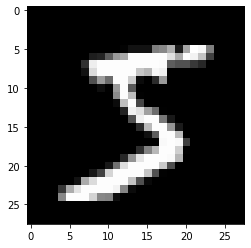

In [4]:
plt.imshow(train_images[0].reshape((28, 28)), cmap='gray')
plt.show()

# Dataset et Dataloader 

In [5]:
class MonDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(float)).float()
        self.y = torch.from_numpy(y.astype(float)).float()
    
    def __getitem__(self, index): 
        return self.x[index], self.y[index] 
    
    def __len__(self):
        return len(self.x)

In [6]:
dataset = MonDataset(train_images, train_labels)
data = torch.utils.data.DataLoader(dataset, 
                                   shuffle=True , batch_size=50) 

# Implémentation d'un autoencodeur 

In [7]:
class Autoencodeur(torch.nn.Module):
    
    def __init__(self, shape, dim_compression):
        super(Autoencodeur, self).__init__()
        self.lin1 = torch.nn.Linear(shape, dim_compression)
        self.lin2 = torch.nn.Linear(dim_compression, shape)
        self.lin2.weight = torch.nn.Parameter(self.lin1.weight.T)
    
    def forward(self, train_x):
        encoder = (self.lin1(train_x))
        #encoder = torch.nn.functional.relu(self.lin1(train_x))
        decoder = torch.sigmoid(self.lin2(encoder))
        return decoder
                      

In [ ]:
nb_epoch = 30
learning_rate=1e-2
auto = Autoencodeur(784, 30)

writer = SummaryWriter()
optim = torch.optim.SGD(params=[auto.lin1.weight, auto.lin1.bias, auto.lin2.bias],lr=learning_rate)
optim.zero_grad()
loss = torch.nn.BCELoss()
# Reinitialisation du gradient
n_iter = 0

for i in range(nb_epoch):
    print('Epoch ',i+1)
    for x,y in data: 
     #   print(torch.max(auto.forward(x)))
        n_iter += 1
        output = loss(auto.forward(x), x/255) 
        writer.add_scalar('Loss/train', output, n_iter)
        output.backward()
        optim.step()
        optim.zero_grad()

Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11


### Visualization of results 

In [ ]:
n_vizualize=5

i = 0
for x,y in data:
    xhat = auto.forward(x)
    plt.imshow(xhat[0].detach().numpy().reshape((28, 28)), cmap='gray')
    plt.show()
    plt.imshow(x[0].detach().numpy().reshape((28, 28)), cmap='gray')
    plt.show()
    
    i += 1
    if i == 5:
        break

# GPU, Checkpointing

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class State:
    def __init__(self,model,optim):
        self.model=model
        self.optim=optim
        self.epoch=0
        self.iteration=0

In [ ]:
if not(os.path.exists("savefile")):
    savefile=os.mknod("savefile")


In [ ]:
savefile=Path("savefile")

In [ ]:
learning_rate=1e-2
nb_epochs=10

if savefile.is_file() and os.path.getsize(savefile)>0:
#On ne récupère les données uniquemenet si le fichier unique et est non vide
    with savefile.open("rb") as fp:
        state=torch.load(fp)
else:
    autoencoder=Autoencodeur(784, 30)
    autoencoder=autoencoder.to(device)
    optim=torch.optim.SGD(params=[autoencoder.lin1.weight,autoencoder.lin1.bias,autoencoder.lin2.bias],lr=learning_rate)
    state=State(autoencoder,optim)
    

In [ ]:
for epoch in range(state.epoch,nb_epochs):
    for x,y in data:
        state.optim.zero_grad()
        x=x.to(device)
        xhat=autoencoder(x)
        l=loss(xhat,x)
        l.backward()
        state.optim.step()
        state.iteration+=1
    if epoch %1==0:
        print("Epoch %d"%epoch)
    with savefile.open("wb") as fp:
        state.epoch+=1
        torch.save(state,fp)
        
